In [1]:
import torch 
import torch.nn as nn
import os
import argparse
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import sys
from PIL import Image
import requests
from io import BytesIO
import urllib.request as url_req
import pickle
from Model import get_model
from utils import *
import json
from model_and_data import Data
from FGSM import FGSM
from BIM import BIM
from visualize import visualise

In [2]:
# %matplotlib inline
# %matplotlib qt

In [3]:
device  = torch.device('cpu')

In [4]:
model = get_model(device)                  # loads a pretrained vgg11 model
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [5]:
def imshow(img,wnid,title=None):
    img = img.cpu().detach().numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    
    img = img*std+mean
#     img = np.clip(img,0,1)
    plt.imshow(img)
    
#     title = getClassOfId(wnid)
    
    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
# url_files = ['valid_urls1.txt','valid_urls2.txt','valid_urls3.txt','valid_urls4.txt','valid_urls5.txt']
# # url_files = ['valid_urls1.txt']
 
# key_to_label_map = pickle.load(open('pickled_id_label_imagenet_map', 'rb')) # load mapping as dict

# for url_file in url_files:
#     with open(url_file) as f:
#         url_dict = json.load(f)
        
#         label_idxs = list(url_dict.keys())
#         print(label_idxs)
#         label = label_idxs[0]
#         key = key_to_label_map[int(label)]['label']
#         print(key,label)
#         url_list = url_dict[label]
#         test_url = url_list[0]
#         test_img = urltoImg(test_url)
        
#         data = Data(model,device, None,None)
#         img_tsor = data.preprocess_data(test_img)
#         img_tsor.unsqueeze_(0)
#         img_tsor = img_tsor.to(device)

#         label = torch.tensor(float(label),requires_grad=False)
#         label = label.to(device)

#         criterion = nn.CrossEntropyLoss()
#         print(img_tsor.size())
#         output = model(img_tsor)
#         _,pred = torch.max(output,1)
#         img_tsor.squeeze_(0)
#         imshow(img_tsor,key)
#         print('Original label = ',float(label))
#         print('Output idx and class =',float(pred.cpu()),',',key_to_label_map[float(pred.cpu())]['label'])


### Save all images

In [7]:
# url_files = ['valid_urls1.txt','valid_urls2.txt','valid_urls3.txt','valid_urls4.txt','valid_urls5.txt']

# for url_file in url_files:
#     with open(url_file) as f:
#         url_dict = json.load(f)
        
#     for label in url_dict.keys():
#         save_imgs(label,url_dict[label])

In [10]:
imgs = os.listdir('imagenet_imgs/')

# epsilon_arr = list(np.linspace(0,1,21))
epsilon_arr = [0.005,0.01,0.05,0.1,0.3,0.6]
batch_size = len(os.listdir('imagenet_imgs/'))
fg_top_one_acc_arr = []
fg_top_five_acc_arr = []
bim_top_one_acc_arr = []
bim_top_five_acc_arr = []
pgd_top_one_acc_arr = []
pgd_top_five_acc_arr = []
unpert_top_one_acc = []
unpert_top_five_acc = []

top_one_misclassfns = {}
top_five_misclassfns = {}


for epsilon in epsilon_arr:
    top_one_misclassfns['unpert'] = 0
    top_one_misclassfns['fgsm'] = 0
    top_one_misclassfns['bim'] = 0
    top_one_misclassfns['pgd'] = 0
    
    # top_one_misclassfn['llc'] = 0

    top_five_misclassfns['unpert'] = 0
    top_five_misclassfns['fgsm'] = 0
    top_five_misclassfns['bim'] = 0
    top_five_misclassfns['pgd'] = 0
    
    # top_five_misclassfn['llc'] = 0
    
    for idx,img_name in enumerate(imgs):
            print(idx)
            img_path = os.path.join('imagenet_imgs/',img_name)
            data = Data(model,device, None,None)
            img_tsor = data.preprocess_data(Image.open(img_path))
    #         imshow(img_tsor,'dgs')
            img_tsor.unsqueeze_(0)
            img_tsor = img_tsor.to(device)
            img_tsor.requires_grad_(True)

            label = img_name.split('_')[0]
            label = torch.tensor([int(label)],requires_grad=False)
            label = label.to(device)
    #         print(label.shape)

            criterion = nn.CrossEntropyLoss()
            ############ Unperturbed Model ######################
            unpert_output,unpert_pred, unpert_op_probs, unpert_pred_prob = getPredictionInfo(model,img_tsor)
            unpert_top_probs, unpert_top_labels = predict_top_five(model,img_tsor,k=5)
            
            top_one_misclassfns['unpert'] = checkMatchingLabels(label,unpert_pred,top_one_misclassfns['unpert'])
            top_five_misclassfns['unpert'] = checkMatchingLabelsTop_five(label,unpert_top_labels,top_five_misclassfns['unpert'])
            model.zero_grad()
            ############### FGSM ################################
            fgsm = FGSM(model,criterion,img_tsor,label,epsilon)
            fg_adv_img,fg_perturbation = fgsm.attack()
            
            fg_output_adv,fg_pred_adv, fg_op_adv_probs, fg_adv_pred_prob  = getPredictionInfo(model,fg_adv_img)
#             output_adv = model(torch.tensor(adv_img))
#             _,pred_adv = torch.max(output_adv.data,1)
#         #     print(adv_img.data-img.data)
#             op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
#             adv_pred_prob =  ((torch.max(op_adv_probs.data, 1)[0][0]) * 100, 4)      #find probability (confidence) of a predicted class

            fg_top_probs,fg_top_labels = predict_top_five(model,fg_adv_img,k=5)

    #         print(int(label),int(pred_adv))
            top_one_misclassfns['fgsm'] = checkMatchingLabels(label,fg_pred_adv,top_one_misclassfns['fgsm'])
            top_five_misclassfns['fgsm'] = checkMatchingLabelsTop_five(label,fg_top_labels,top_five_misclassfns['fgsm'])
            model.zero_grad()
            ################ BIM ##############################
            bim = BIM(model,criterion,img_tsor,label,epsilon,epsilon/2,num_iters=0,random_state=False)
            
            bim_adv_img,bim_perturbation,bim_loss = bim.attack()
            
            bim_output_adv,bim_pred_adv, bim_op_adv_probs, bim_adv_pred_prob  = getPredictionInfo(model,bim_adv_img)
            
            bim_top_probs,bim_top_labels = predict_top_five(model,bim_adv_img,k=5)


            top_one_misclassfns['bim'] = checkMatchingLabels(label,bim_pred_adv,top_one_misclassfns['bim'])
            top_five_misclassfns['bim'] = checkMatchingLabelsTop_five(label,bim_top_labels,top_five_misclassfns['bim'])
            model.zero_grad()
            ########################## PGD  #####################
            
            pgd = BIM(model,criterion,img_tsor,label,epsilon,0.001,num_iters=6,random_state=True)
            
            pgd_adv_img,pgd_perturbation,pgd_loss = pgd.attack()
            
            pgd_output_adv,pgd_pred_adv, pgd_op_adv_probs, pgd_adv_pred_prob  = getPredictionInfo(model,pgd_adv_img)
            
            pgd_top_probs,pgd_top_labels = predict_top_five(model,pgd_adv_img,k=5)


            top_one_misclassfns['pgd'] = checkMatchingLabels(label,pgd_pred_adv,top_one_misclassfns['pgd'])
            top_five_misclassfns['pgd'] = checkMatchingLabelsTop_five(label,pgd_top_labels,top_five_misclassfns['pgd'])
            
            model.zero_grad()
            
            
            
#             if (int(label) not in unpert_top_labels.astype(int)):
#                 unpert_top_five_misclassfns+=1
            
#             if (int(label)!=int(pred_adv)):
#                 top_one_misclassfns+=1

#             if(int(label) not in top_labels.astype(int)):
#                 top_five_misclassfns+=1
                
    unpert_top_one_acc.append(1-(top_one_misclassfns['unpert']/batch_size))
    unpert_top_five_acc.append(1-(top_five_misclassfns['unpert']/batch_size))
    fg_top_one_acc_arr.append(1-(top_one_misclassfns['fgsm']/batch_size))
    fg_top_five_acc_arr.append(1-(top_five_misclassfns['fgsm']/batch_size))
    bim_top_one_acc_arr.append(1-(top_one_misclassfns['bim']/batch_size))
    bim_top_five_acc_arr.append(1-(top_five_misclassfns['bim']/batch_size))
    pgd_top_one_acc_arr.append(1-(top_one_misclassfns['pgd']/batch_size))
    pgd_top_five_acc_arr.append(1-(top_five_misclassfns['pgd']/batch_size))
    
    
    print('Unpert Top 1 Accuracy :',1-(top_one_misclassfns['unpert']/batch_size))
    print('Unpert Top 5 Accuracy :',1-(top_five_misclassfns['unpert']/batch_size))
    print('Top 1 FGSM Accuracy :',1-(top_one_misclassfns['fgsm']/batch_size))
    print('Top 5 FGSM Accuracy :',1-(top_five_misclassfns['fgsm']/batch_size))
    print('Top 1 BIM Accuracy :',1-(top_one_misclassfns['bim']/batch_size))
    print('Top 5 BIM Accuracy :',1-(top_five_misclassfns['bim']/batch_size))
    print('Top 1 PGD Accuracy :',1-(top_one_misclassfns['pgd']/batch_size))
    print('Top 5 PGD Accuracy :',1-(top_five_misclassfns['pgd']/batch_size))

# plt.figure()
# plt.title('Top-1 Accuracy for FGSM and BIM vs Epsilon')
# plt.plot(epsilon_arr,unpert_top_one_acc, label='Unperturbed Model')
# plt.plot(epsilon_arr,fg_top_one_acc_arr,label='FGSM')
# plt.plot(epsilon_arr,bim_top_one_acc_arr,label='BIM')
# plt.ylabel('Top-1 Accuracy')
# plt.xlabel('Epsilon')
# plt.legend()


# plt.figure()
# plt.title('Top-5 Accuracy for FGSM and BIM vs Epsilon')
# plt.plot(epsilon_arr,unpert_top_five_acc)
# plt.plot(epsilon_arr,top_five_acc_arr,label='FGSM')
# plt.plot(epsilon_arr,bim_top_five_acc_arr,label='BIM')
# plt.ylabel('Top-5 Accuracy')
# plt.xlabel('Epsilon')
# plt.legend()
# plt.show()
# #         visualise(img_tsor,perturbation,adv_img,label,label,pred_prob,pred_adv,adv_pred_prob,epsilon,topkProb=top_probs,topkLabel=top_labels)



0
1
2
3
4
5
6
7
8
9
Unpert Top 1 Accuracy : 1.0
Unpert Top 5 Accuracy : 1.0
Top 1 FGSM Accuracy : 0.6
Top 5 FGSM Accuracy : 0.9
Top 1 BIM Accuracy : 0.6
Top 5 BIM Accuracy : 1.0
Top 1 PGD Accuracy : 0.6
Top 5 PGD Accuracy : 0.9
0
1
2
3
4
5
6
7
8
9
Unpert Top 1 Accuracy : 1.0
Unpert Top 5 Accuracy : 1.0
Top 1 FGSM Accuracy : 0.19999999999999996
Top 5 FGSM Accuracy : 0.8
Top 1 BIM Accuracy : 0.6
Top 5 BIM Accuracy : 0.9
Top 1 PGD Accuracy : 0.5
Top 5 PGD Accuracy : 0.9
0
1
2
3
4
5
6
7
8
9
Unpert Top 1 Accuracy : 1.0
Unpert Top 5 Accuracy : 1.0
Top 1 FGSM Accuracy : 0.0
Top 5 FGSM Accuracy : 0.30000000000000004
Top 1 BIM Accuracy : 0.0
Top 5 BIM Accuracy : 0.4
Top 1 PGD Accuracy : 0.4
Top 5 PGD Accuracy : 0.8


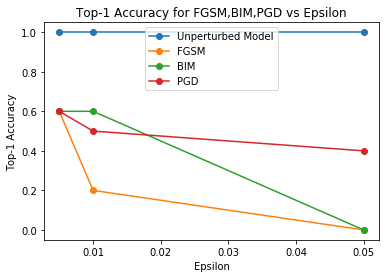

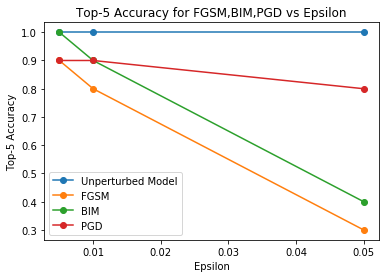

Epsilon [0.005, 0.01, 0.05]
Unperturbed
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
FGSM
[0.6, 0.19999999999999996, 0.0]
[0.9, 0.8, 0.30000000000000004]
BIM
[0.6, 0.6, 0.0]
[1.0, 0.9, 0.4]
PGD
[0.6, 0.5, 0.4]
[0.9, 0.9, 0.8]
DONE DONA DONE


In [12]:
# epsilon_arr = [0.05]
plt.figure()
plt.title('Top-1 Accuracy for FGSM,BIM,PGD vs Epsilon')
plt.plot(epsilon_arr,unpert_top_one_acc, label='Unperturbed Model',marker='o')
plt.plot(epsilon_arr,fg_top_one_acc_arr,label='FGSM',marker='o')
plt.plot(epsilon_arr,bim_top_one_acc_arr,label='BIM',marker='o')
plt.plot(epsilon_arr,pgd_top_one_acc_arr,label='PGD',marker='o')
plt.ylabel('Top-1 Accuracy')
plt.xlabel('Epsilon')
plt.legend()


plt.figure()
plt.title('Top-5 Accuracy for FGSM,BIM,PGD vs Epsilon')
plt.plot(epsilon_arr,unpert_top_five_acc,label='Unperturbed Model',marker='o')
plt.plot(epsilon_arr,fg_top_five_acc_arr,label='FGSM',marker='o')
plt.plot(epsilon_arr,bim_top_five_acc_arr,label='BIM',marker='o')
plt.plot(epsilon_arr,pgd_top_five_acc_arr,label='PGD',marker='o')
plt.ylabel('Top-5 Accuracy')
plt.xlabel('Epsilon')
plt.legend()
plt.show()
#         visualise(img_tsor,perturbation,adv_img,label,label,pred_prob,pred_adv,adv_pred_prob,epsilon,topkProb=top_probs,topkLabel=top_labels)
print('Epsilon',epsilon_arr)
print('Unperturbed')
print(unpert_top_one_acc)
print(unpert_top_five_acc)
print('FGSM')
print(fg_top_one_acc_arr)
print(fg_top_five_acc_arr)
print('BIM')
print(bim_top_one_acc_arr)
print(bim_top_five_acc_arr)
print('PGD')
print(pgd_top_one_acc_arr)
print(pgd_top_five_acc_arr)
print('DONE DONA DONE')